In [1]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

In [17]:
def compute_rmse(ytrue, ypred, mask=None):
    if mask is not None:
        selection =mask.ravel()
        ytrue_sel =ytrue.ravel()[selection]
        ypred_sel =ypred.ravel()[selection]
    else:
        ytrue_sel =ytrue.ravel()
        ypred_sel =ypred.ravel()

    # Ensure we are not comparing NaNs
    valid = ~np.isnan(ytrue_sel) & ~np.isnan(ypred_sel)
    if valid.sum() == 0:
        return np.nan
    return np.sqrt(np.mean((ytrue_sel[valid] - ypred_sel[valid]) ** 2))


def compute_psnr(ytrue, ypred, maxval=255.0):
    mse = np.mean((ytrue.ravel() - ypred.ravel()) ** 2)
    if mse == 0 or np.isnan(mse):
        return np.nan
    return 20 * np.log10(maxval / np.sqrt(mse))

def matrix_factorization_gd_adam(data, rank, learning_rate=0.005, epochs=2000, lambda_reg=0.05,
                                 beta1=0.9, beta2=0.999, eps=1e-8, clip_value=1e6,
                                 print_every=500, normalize=True, verbose=True):
    # Make a copy and mask
    data = np.asarray(data, dtype=np.float64)
    observed_mask = ~np.isnan(data)
    m, n = data.shape

    observed_vals = data[observed_mask]
    datamin, datamax = observed_vals.min(), observed_vals.max()
    scale = datamax - datamin if datamax != datamin else 1.0
    datasc = (data - datamin) / scale
    datasc[~observed_mask] = np.nan
    
    rng = np.random.default_rng(42)
    P = rng.normal(0, 0.1, size=(m, rank)) 
    Q = rng.normal(0, 0.1, size=(n, rank))
    mP, vP = np.zeros_like(P), np.zeros_like(P)
    mQ, vQ = np.zeros_like(Q), np.zeros_like(Q)
    mu = np.nanmean(datasc)
    prev_loss = np.inf

    for epoch in range(1, epochs + 1):
        pred = P @ Q.T + mu
        error = (pred - np.nan_to_num(datasc, nan=0.0)) * observed_mask

        # Gradients with regularization
        gradP = 2 * error @ Q + lambda_reg * P
        gradQ = 2 * error.T @ P + lambda_reg * Q

        # Adam optimizer updates
        t = epoch
        mP = beta1 * mP + (1 - beta1) * gradP
        vP = beta2 * vP + (1 - beta2) * (gradP ** 2)
        mP_hat = mP / (1 - beta1 ** t)
        vP_hat = vP / (1 - beta2 ** t)
        P -= learning_rate * mP_hat / (np.sqrt(vP_hat) + eps)

        mQ = beta1 * mQ + (1 - beta1) * gradQ
        vQ = beta2 * vQ + (1 - beta2) * (gradQ ** 2)
        mQ_hat = mQ / (1 - beta1 ** t)
        vQ_hat = vQ / (1 - beta2 ** t)
        Q -= learning_rate * mQ_hat / (np.sqrt(vQ_hat) + eps)

        if verbose and (epoch % print_every == 0 or epoch == epochs):
            loss = np.sum(error ** 2) + lambda_reg * (np.sum(P**2) + np.sum(Q**2))
            print(f"Epoch {epoch:4d} | Loss: {loss:.4f}")

    # Denormalize the final reconstruction
    recon = (P @ Q.T + mu) * scale + datamin
    return recon



In [18]:
def matrix_factorization_als(data, r, num_iterations=10):
    m, n = data.shape
    dtype = torch.float32
    P = torch.rand(m, r, dtype=dtype)
    Q = torch.rand(n, r, dtype=dtype)
    data_tensor = torch.from_numpy(data).to(dtype)
    
    # Create a mask of the non-missing entries
    mask = ~torch.isnan(data_tensor)

    for i in range(num_iterations):
        # Fix Q and solve for P
        for j in range(m):
            observed_indices = mask[j, :].nonzero().squeeze()
            if len(observed_indices.shape) > 0 and observed_indices.numel() > 0:
                q_subset = Q[observed_indices, :]
                d_subset = data_tensor[j, observed_indices]
                P[j, :] = torch.linalg.lstsq(q_subset, d_subset).solution

        # Fix P and solve for Q
        for k in range(n):
            observed_indices = mask[:, k].nonzero().squeeze()
            if len(observed_indices.shape) > 0 and observed_indices.numel() > 0:
                p_subset = P[observed_indices, :]
                d_subset = data_tensor[observed_indices, k]
                Q[k, :] = torch.linalg.lstsq(p_subset, d_subset).solution
                
    return (P @ Q.T).numpy()

In [19]:
def reconstruct_image(image_path, rank, missing_type='block'):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img, dtype=float) / 255.0


    missing_img_array = img_array.copy()
    if missing_type == 'block':
        missing_img_array[50:80, 50:80] = np.nan
    else:
        idx = np.random.choice(img_array.size, 900, replace=False)
        missing_img_array.flat[idx] = np.nan

    
    reconstructed_gd = matrix_factorization_gd_adam(missing_img_array, rank=rank)

    reconstructed_als = matrix_factorization_als(missing_img_array, r=rank)

    # --- Calculate metrics ---

    if missing_type == 'block':
        original_patch = img_array[50:80, 50:80].ravel()
        gd_patch = reconstructed_gd[50:80, 50:80].ravel()
        als_patch = reconstructed_als[50:80, 50:80].ravel()
    else:
        original_patch = img_array.flatten()[idx]
        gd_patch = reconstructed_gd.flatten()[idx]
        als_patch = reconstructed_als.flatten()[idx]

    rmse_gd = np.sqrt(mse(original_patch, gd_patch))
    rmse_als = np.sqrt(mse(original_patch, als_patch))

    # PSNR on full image
    psnr_gd = psnr(img_array, reconstructed_gd, data_range=255)
    psnr_als = psnr(img_array, reconstructed_als, data_range=255)

    print(f"--- {missing_type.capitalize()} Missing Data ---")
    print(f"GD  - RMSE (missing): {rmse_gd:.4f}, PSNR (full): {psnr_gd:.4f}")
    print(f"ALS - RMSE (missing): {rmse_als:.4f}, PSNR (full): {psnr_als:.4f}")


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1); plt.imshow(img_array, cmap='gray'); plt.title('Original')
    plt.subplot(1, 4, 2); plt.imshow(np.nan_to_num(missing_img_array, nan=0), cmap='gray'); plt.title('Missing Data')
    plt.subplot(1, 4, 3); plt.imshow(reconstructed_gd, cmap='gray'); plt.title('Reconstructed (GD)')
    plt.subplot(1, 4, 4); plt.imshow(reconstructed_als, cmap='gray'); plt.title('Reconstructed (ALS)')
    plt.show()

    # --- PLOT 2: Zoomed-in Regions (New Addition) ---
    if missing_type == 'block':
        # Crop to the 30x30 region for zoomed-in comparison
        
        # Original ground truth patch
        original_patch = img_array[50:80, 50:80]
        
        # Reconstructed patches
        gd_patch = reconstructed_gd[50:80, 50:80]
        als_patch = reconstructed_als[50:80, 50:80]
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.imshow(original_patch, cmap='gray'); plt.title('Original (Zoom)')
        plt.subplot(1, 3, 2); plt.imshow(gd_patch, cmap='gray'); plt.title('GD Reconstructed (Zoom)')
        plt.subplot(1, 3, 3); plt.imshow(als_patch, cmap='gray'); plt.title('ALS Reconstructed (Zoom)')
        plt.suptitle(f"Zoomed View of Missing Block (Rank r={rank})")
        plt.show()



Epoch  500 | Loss: 770.2608
Epoch 1000 | Loss: 765.6235
Epoch 1500 | Loss: 764.4098
Epoch 2000 | Loss: 763.8162
--- Block Missing Data ---
GD  - RMSE (missing): 0.2874, PSNR (full): 75.3356
ALS - RMSE (missing): 0.0904, PSNR (full): 75.7072


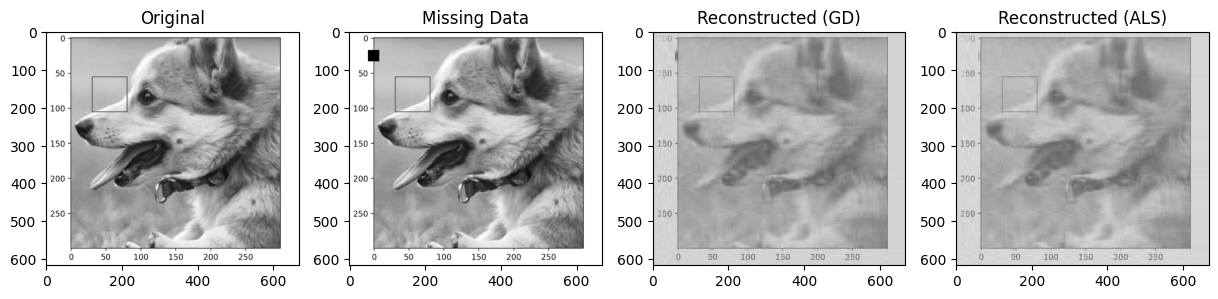

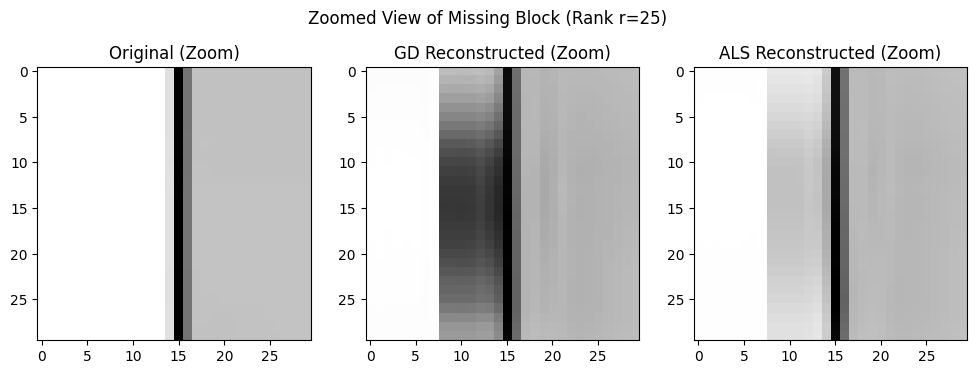

Epoch  500 | Loss: 769.1553
Epoch 1000 | Loss: 764.8595
Epoch 1500 | Loss: 763.9548
Epoch 2000 | Loss: 763.0854
--- Random Missing Data ---
GD  - RMSE (missing): 0.0468, PSNR (full): 75.7588
ALS - RMSE (missing): 0.0470, PSNR (full): 75.7481


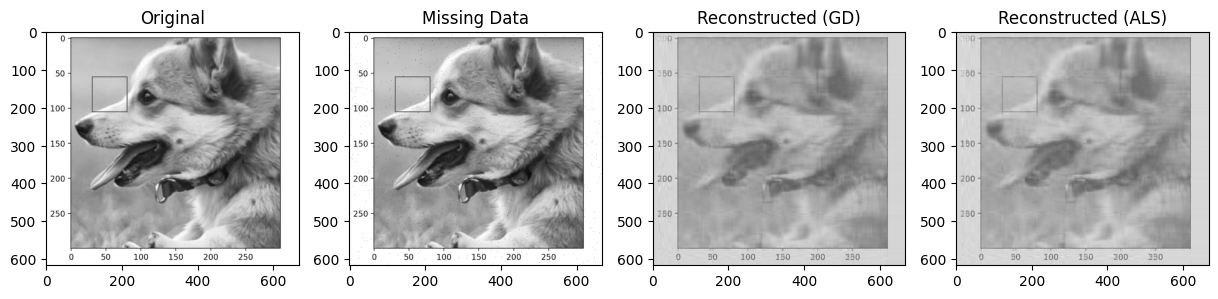

In [20]:
image_to_reconstruct = './sample_images/2-3_colours.jpg'
chosen_rank = 25
reconstruct_image(image_to_reconstruct, rank=chosen_rank, missing_type='block')
reconstruct_image(image_to_reconstruct, rank=chosen_rank, missing_type='random')

## PART B

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import mean_squared_error as mse

def compress_patch(image_path, patch_coords, ranks, patch_title):
    img = Image.open(image_path)
    img_array = np.array(img, dtype=float)
    
    y1, y2, x1, x2 = patch_coords
    original_patch = img_array[y1:y2, x1:x2]
    
    fig, axs = plt.subplots(2, len(ranks), figsize=(15, 6))
    fig.suptitle(f"Color Compression of '{patch_title}' Patch", fontsize=16)

    axs[0, 0].imshow(original_patch.astype(np.uint8))
    axs[0, 0].set_title("Original Patch\n(50x50)")
    
    for i in range(1, len(ranks)):
        axs[0, i].axis('off')

    print(f"\n### Compressing Color Patch: {patch_title} ###")

    for i, r in enumerate(ranks):
        print(f"Processing with rank r={r}")
        
        reconstructed_channels = []
        for channel in range(3):
            original_channel = original_patch[:, :, channel]
            reconstructed_channel = matrix_factorization_gd_adam(original_channel, r)
            reconstructed_channels.append(reconstructed_channel)
        
    
        reconstructed_patch = np.stack(reconstructed_channels, axis=-1)
        

        reconstructed_patch = np.clip(reconstructed_patch, 0, 255)
        

        rmse = np.sqrt(mse(original_patch, reconstructed_patch))
        
        ax = axs[1, i]

        ax.imshow(reconstructed_patch.astype(np.uint8))
        ax.set_title(f"Rank r={r}\nRMSE: {rmse:.2f}")

    for ax in axs.flat:
        ax.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### Compressing Color Patch: Single Color ###
Processing with rank r=5
Epoch  500 | Loss: 3.8934
Epoch 1000 | Loss: 3.7489
Epoch 1500 | Loss: 3.7248
Epoch 2000 | Loss: 3.7225
Epoch  500 | Loss: 4.7669
Epoch 1000 | Loss: 3.9372
Epoch 1500 | Loss: 3.4700
Epoch 2000 | Loss: 3.2371
Epoch  500 | Loss: 5.1088
Epoch 1000 | Loss: 4.2061
Epoch 1500 | Loss: 3.7021
Epoch 2000 | Loss: 3.4657
Processing with rank r=10
Epoch  500 | Loss: 2.8697
Epoch 1000 | Loss: 2.7547
Epoch 1500 | Loss: 2.7458
Epoch 2000 | Loss: 2.7455
Epoch  500 | Loss: 4.5171
Epoch 1000 | Loss: 3.5902
Epoch 1500 | Loss: 3.2269
Epoch 2000 | Loss: 3.1013
Epoch  500 | Loss: 4.6279
Epoch 1000 | Loss: 3.7097
Epoch 1500 | Loss: 3.3695
Epoch 2000 | Loss: 3.2553
Processing with rank r=25
Epoch  500 | Loss: 2.5586
Epoch 1000 | Loss: 2.4985
Epoch 1500 | Loss: 2.4974
Epoch 2000 | Loss: 2.4974
Epoch  500 | Loss: 3.8111
Epoch 1000 | Loss: 3.2158
Epoch 1500 | Loss: 3.0909
Epoch 2000 | Loss: 3.0672
Epoch  500 | Loss: 3.9038
Epoch 1000 | Loss:

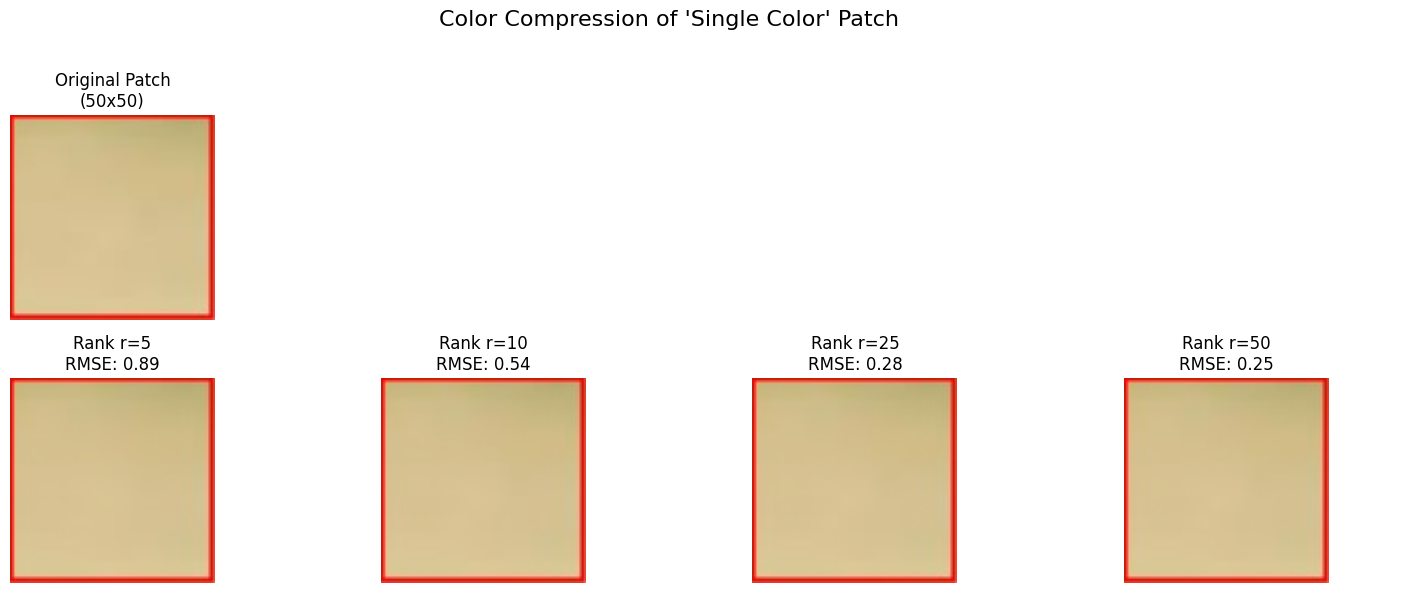


### Compressing Color Patch: 2-3 Colors ###
Processing with rank r=5
Epoch  500 | Loss: 31.5441
Epoch 1000 | Loss: 31.2845
Epoch 1500 | Loss: 31.1757
Epoch 2000 | Loss: 31.1413
Epoch  500 | Loss: 9.3165
Epoch 1000 | Loss: 8.4630
Epoch 1500 | Loss: 8.1331
Epoch 2000 | Loss: 7.9984
Epoch  500 | Loss: 12.0860
Epoch 1000 | Loss: 11.7505
Epoch 1500 | Loss: 11.6068
Epoch 2000 | Loss: 11.5579
Processing with rank r=10
Epoch  500 | Loss: 9.6266
Epoch 1000 | Loss: 9.4553
Epoch 1500 | Loss: 9.4269
Epoch 2000 | Loss: 9.4237
Epoch  500 | Loss: 4.9020
Epoch 1000 | Loss: 4.3391
Epoch 1500 | Loss: 4.1897
Epoch 2000 | Loss: 4.1513
Epoch  500 | Loss: 4.9987
Epoch 1000 | Loss: 4.6030
Epoch 1500 | Loss: 4.5518
Epoch 2000 | Loss: 4.5448
Processing with rank r=25
Epoch  500 | Loss: 6.2300
Epoch 1000 | Loss: 6.0033
Epoch 1500 | Loss: 5.9899
Epoch 2000 | Loss: 5.9890
Epoch  500 | Loss: 4.3593
Epoch 1000 | Loss: 3.9642
Epoch 1500 | Loss: 3.9040
Epoch 2000 | Loss: 3.8962
Epoch  500 | Loss: 4.4682
Epoch 1000 |

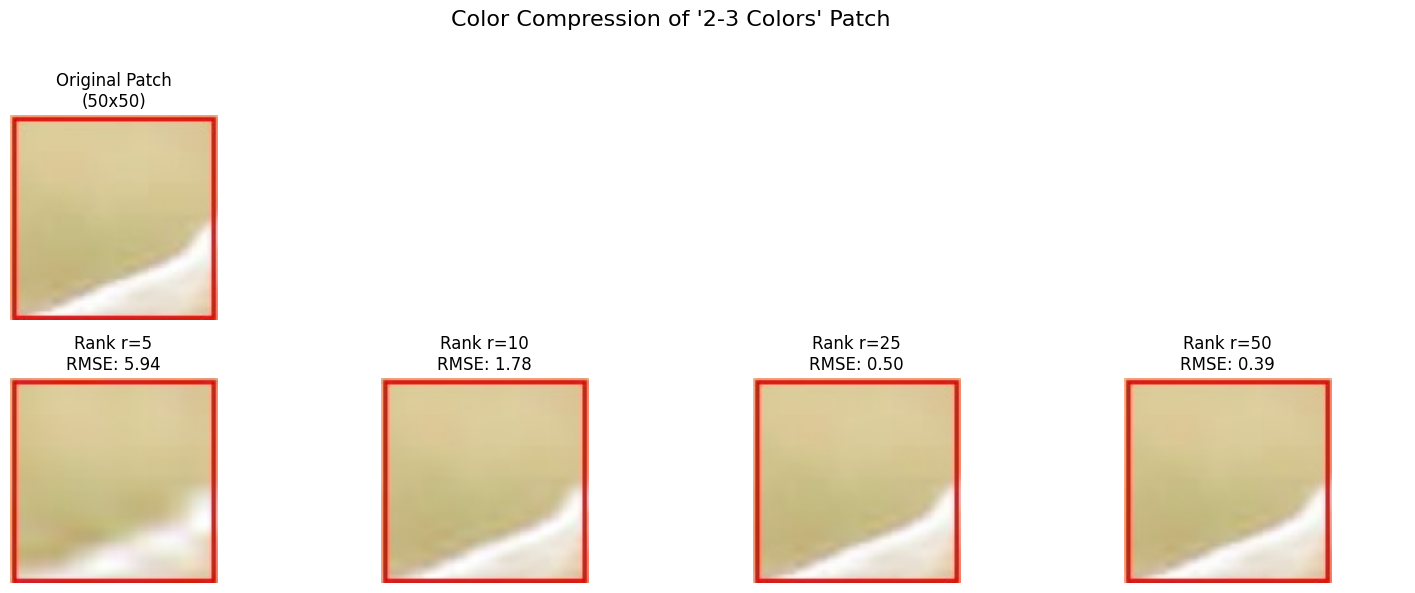


### Compressing Color Patch: Multiple Colors ###
Processing with rank r=5
Epoch  500 | Loss: 34.8585
Epoch 1000 | Loss: 34.7742
Epoch 1500 | Loss: 34.7592
Epoch 2000 | Loss: 34.7576
Epoch  500 | Loss: 27.2814
Epoch 1000 | Loss: 27.1810
Epoch 1500 | Loss: 27.1551
Epoch 2000 | Loss: 27.1507
Epoch  500 | Loss: 24.7156
Epoch 1000 | Loss: 24.6540
Epoch 1500 | Loss: 24.6498
Epoch 2000 | Loss: 24.6496
Processing with rank r=10
Epoch  500 | Loss: 10.4572
Epoch 1000 | Loss: 10.3456
Epoch 1500 | Loss: 10.3390
Epoch 2000 | Loss: 10.3387
Epoch  500 | Loss: 9.0189
Epoch 1000 | Loss: 8.9245
Epoch 1500 | Loss: 8.9145
Epoch 2000 | Loss: 8.9139
Epoch  500 | Loss: 7.7516
Epoch 1000 | Loss: 7.7212
Epoch 1500 | Loss: 7.7203
Epoch 2000 | Loss: 7.7203
Processing with rank r=25
Epoch  500 | Loss: 5.5414
Epoch 1000 | Loss: 5.4432
Epoch 1500 | Loss: 5.4409
Epoch 2000 | Loss: 5.4409
Epoch  500 | Loss: 5.8006
Epoch 1000 | Loss: 5.6414
Epoch 1500 | Loss: 5.6373
Epoch 2000 | Loss: 5.6372
Epoch  500 | Loss: 4.5652

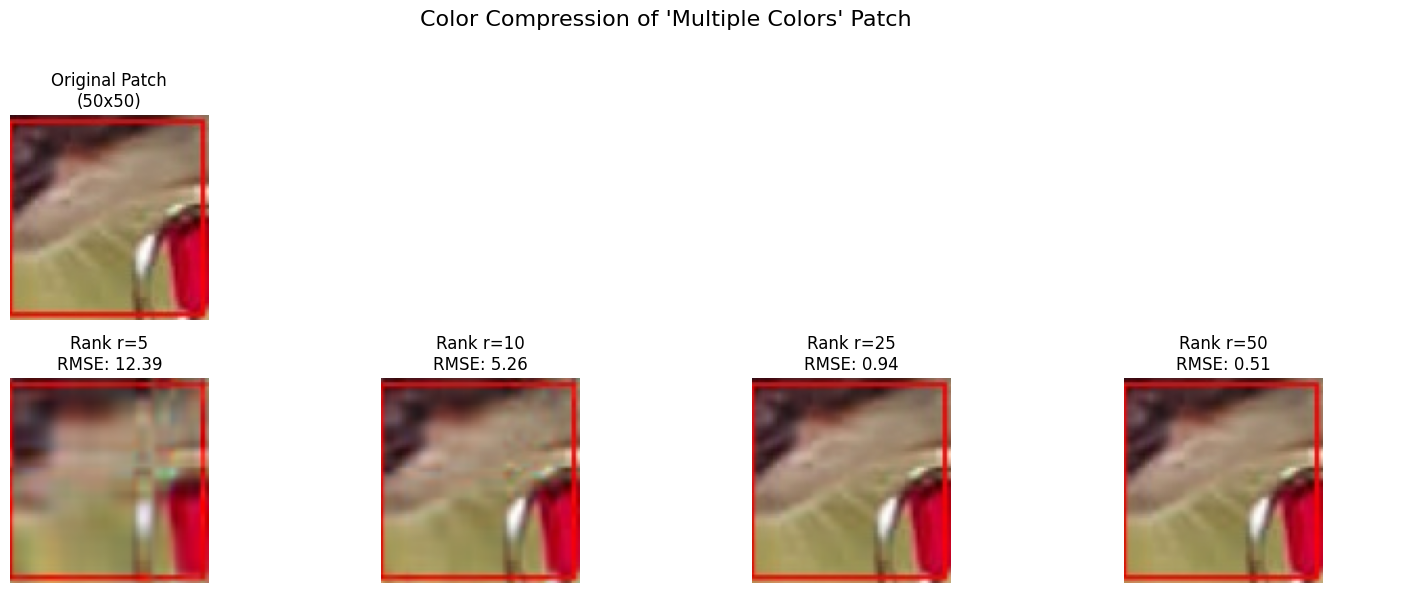

In [22]:
image_paths = {
    "single_color": './sample_images/1colour.jpg',
    "2-3_colors": './sample_images/2-3_colours.jpg',
    "multiple_colors": './sample_images/multiple_colours.jpg'
}

patch_definitions = {
    "Single Color": (image_paths["single_color"], (26, 120, 68, 162)),
    "2-3 Colors": (image_paths["2-3_colors"], (119, 214, 120, 216)),
    "Multiple Colors": (image_paths["multiple_colors"], (345, 443, 225, 320))
}


ranks_to_test = [5, 10, 25, 50]


for title, (path, coords) in patch_definitions.items():
    compress_patch(image_path=path, patch_coords=coords, ranks=ranks_to_test, patch_title=title)